In [1]:
import path
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import confusion_matrix as cmat
import preprocessing as pp

from sklearn.metrics import classification_report

In [2]:
np.random.seed(13)
tf.random.set_seed(13)

In [3]:
games = pd.read_csv('data/csv/game.csv')
id_train = np.load('data/result_no_measures/numpy/id_train.npy')

In [4]:
games = games.loc[games['game_id'].isin(id_train), :]
games['result'] = games.loc[:, 'outcome'].apply(pp.result)

In [5]:
n_ties = games[games['result']=='b_tie'].shape[0]
print(n_ties)

2125


In [6]:
home_wins = games[games['result']=='a_home_win'].iloc[:n_ties]
ties = games[games['result']=='b_tie'].iloc[:n_ties]
away_wins = games[games['result']=='c_away_win'].iloc[:n_ties]

In [7]:
games = pd.concat([home_wins, ties, away_wins])

In [8]:
X_train, X_test, y_train, y_test = pp.preprocess(games=games, save_id=False)[:4]

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5100, 366, 12)
(1275, 366, 12)
(5100, 3)
(1275, 3)


In [10]:
X_train = np.concatenate((X_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)

In [11]:
X_test, y_test = pp.load_data('result_no_measures')[1:4:2]

/home/daniel/Asiakirjat/GitHub/Gradu


In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# print(list(X_columns.keys()))
# print(list(y_columns.keys()))

(6375, 366, 12)
(2249, 366, 12)
(6375, 3)
(2249, 3)


In [13]:
print(np.sum(y_train, axis=0))
print(np.sum(y_test, axis=0))

[2125 2125 2125]
[957 531 761]


In [14]:
model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model_mlp.fit(X_train, y_train, epochs=10, validation_split=0.2)
model_mlp.evaluate(X_test, y_test, verbose=0)

Train on 5100 samples, validate on 1275 samples
Epoch 1/10
5100/5100 [==============================] - 3s 576us/sample - loss: 1.1294 - accuracy: 0.3394 - val_loss: 1.0928 - val_accuracy: 0.3804
Epoch 2/10
5100/5100 [==============================] - 3s 558us/sample - loss: 1.0597 - accuracy: 0.4363 - val_loss: 1.0616 - val_accuracy: 0.4329
Epoch 3/10
5100/5100 [==============================] - 3s 605us/sample - loss: 0.9861 - accuracy: 0.5206 - val_loss: 1.0365 - val_accuracy: 0.4361
Epoch 4/10
5100/5100 [==============================] - 3s 609us/sample - loss: 0.9374 - accuracy: 0.5543 - val_loss: 1.0215 - val_accuracy: 0.4839
Epoch 5/10
5100/5100 [==============================] - 3s 610us/sample - loss: 0.8920 - accuracy: 0.5745 - val_loss: 1.0279 - val_accuracy: 0.4533
Epoch 6/10
5100/5100 [==============================] - 3s 545us/sample - loss: 0.8532 - accuracy: 0.6045 - val_loss: 1.0382 - val_accuracy: 0.4400
Epoch 7/10
5100/5100 [==============================] - 3s 601us

[1.018672710871792, 0.48999554]

In [16]:
y_pred_mlp = model_mlp.predict(X_test)

In [17]:
classes = ['home win', 'tie (OT/SO)', 'away win']
for i in range(len(classes)):
    print("Predicted result " + classes[i] + ":", np.sum(y_pred_mlp.argmax(axis=1) == i))

Predicted result home win: 789
Predicted result tie (OT/SO): 745
Predicted result away win: 715


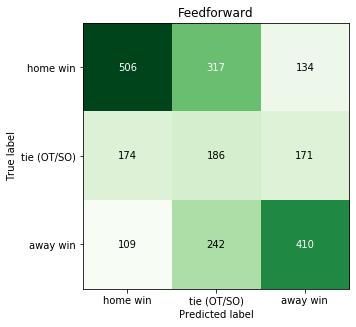

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

cmat.plot(y_test, y_pred_mlp, classes=classes, normalize=False, title="Feedforward",
            show_colorbar=False, ax=ax)

fig.tight_layout()
fig.savefig('img/confusion_matrix_mlp_balanced.png')

In [19]:
model_conv1d = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 12, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(16, 6, activation='relu'),
    tf.keras.layers.Conv1D(16, 6, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model_conv1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model_conv1d.fit(X_train, y_train, epochs=10, validation_split=0.2)
model_conv1d.evaluate(X_test, y_test, verbose=2)

Train on 5100 samples, validate on 1275 samples
Epoch 1/10
5100/5100 [==============================] - 7s 1ms/sample - loss: 1.0999 - accuracy: 0.3304 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/10
5100/5100 [==============================] - 7s 1ms/sample - loss: 1.0988 - accuracy: 0.3351 - val_loss: 1.0986 - val_accuracy: 0.3514
Epoch 3/10
5100/5100 [==============================] - 7s 1ms/sample - loss: 1.0988 - accuracy: 0.3345 - val_loss: 1.0985 - val_accuracy: 0.3325
Epoch 4/10
5100/5100 [==============================] - 7s 1ms/sample - loss: 1.0986 - accuracy: 0.3355 - val_loss: 1.0984 - val_accuracy: 0.3333
Epoch 5/10
5100/5100 [==============================] - 7s 1ms/sample - loss: 1.0988 - accuracy: 0.3386 - val_loss: 1.0983 - val_accuracy: 0.3380
Epoch 6/10
5100/5100 [==============================] - 7s 1ms/sample - loss: 1.0986 - accuracy: 0.3359 - val_loss: 1.0987 - val_accuracy: 0.3365
Epoch 7/10
5100/5100 [==============================] - 7s 1ms/sample - loss

[1.0931663525904904, 0.42552245]

In [21]:
y_pred_conv1d = model_conv1d.predict(X_test) 

In [22]:
for i in range(len(classes)):
    print("Predicted result " + classes[i] + ":", np.sum(y_pred_conv1d.argmax(axis=1) == i))

Predicted result home win: 2249
Predicted result tie (OT/SO): 0
Predicted result away win: 0


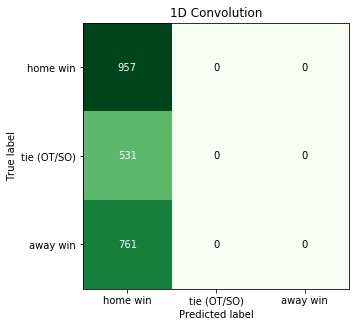

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

cmat.plot(y_test, y_pred_conv1d, classes=classes, normalize=False, title="1D Convolution",
            show_colorbar=False, ax=ax)

fig.tight_layout()
fig.savefig('img/confusion_matrix_conv1d_balanced.png')